In [1]:
import sys

sys.path.append("/workspace/circuit-finder")

from circuit_finder.pretrained import load_model
from circuit_finder.pretrained import load_attn_saes, load_hooked_mlp_transcoders
from circuit_finder.patching.indirect_leap import preprocess_attn_saes

model = load_model()
attn_sae_dict = load_attn_saes()
attn_sae_dict = preprocess_attn_saes(attn_sae_dict, model)
hooked_mlp_transcoder_dict = load_hooked_mlp_transcoders()

attn_saes = list(attn_sae_dict.values())
transcoders = list(hooked_mlp_transcoder_dict.values())

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

In [2]:
from datasets import load_dataset

dataset = load_dataset("c4", "en", streaming=True)

/workspace/circuit-finder/.venv/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for c4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/c4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


/root/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


In [3]:
import torch
from circuit_finder.patching.ablate import splice_model_with_saes_and_transcoders

torch.set_grad_enabled(False)


def get_avg_ce_loss(model, transcoders, saes, dataset, total_tokens=100_000):
    n_tokens = 0
    total_loss = 0
    n_examples = 0

    # Run the model
    print(len(transcoders), len(saes))
    with splice_model_with_saes_and_transcoders(model, transcoders, saes):
        for element in dataset["train"]:
            text = element["text"]
            loss = model(text, return_type="loss")
            total_loss += loss.item()

            tokens = model.to_tokens(text)
            assert tokens.shape[0] == 1
            n = tokens.shape[1]

            n_tokens += n
            n_examples += 1
            if n_tokens >= total_tokens:
                break

    return total_loss / n_examples

In [4]:
clean_loss = get_avg_ce_loss(model, [], [], dataset)
splice_loss_with_error = get_avg_ce_loss(model, transcoders, attn_saes, dataset)

print(clean_loss, splice_loss_with_error)

# Get loss when splicing in SAEs individually
attn_splice_losses = []
for attn_sae in attn_saes:
    attn_sae.cfg.use_error_term = False
    splice_loss = get_avg_ce_loss(model, [], [attn_sae], dataset)
    attn_sae.cfg.use_error_term = True

    attn_splice_losses.append(splice_loss)

transcoder_splice_losses = []
for transcoder in transcoders:
    transcoder.cfg.use_error_term = False
    splice_loss = get_avg_ce_loss(model, [transcoder], [], dataset)
    transcoder.cfg.use_error_term = True
    transcoder_splice_losses.append(splice_loss)

0 0
12 12
3.609104045962922 3.609104007596714
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0


Text(0.5, 1.0, 'Splice Average CE Losses for Attention SAEs')

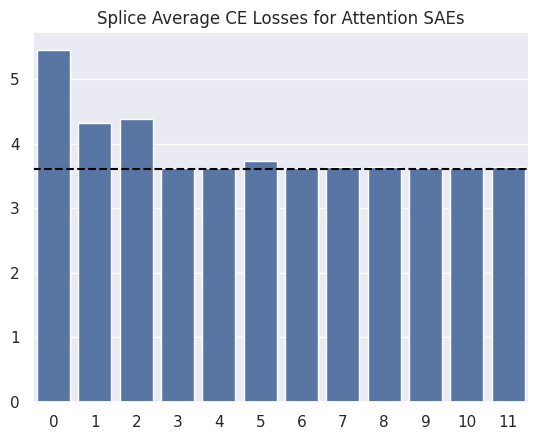

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_theme()

sns.barplot(y=attn_splice_losses, x=list(range(len(attn_splice_losses))))
plt.axhline(y=clean_loss, color="black", linestyle="--")
plt.title("Splice Average CE Losses for Attention SAEs")

Text(0.5, 1.0, 'Spliced Average CE Losses for MLP Transcoders')

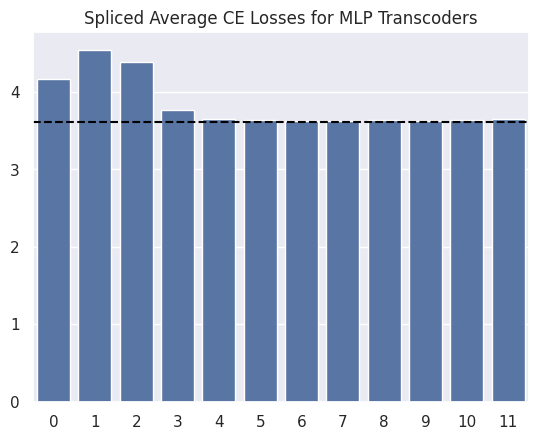

In [6]:
sns.barplot(y=transcoder_splice_losses, x=list(range(len(transcoder_splice_losses))))
plt.axhline(y=clean_loss, color="black", linestyle="--")
plt.title("Spliced Average CE Losses for MLP Transcoders")

In [7]:
for attn_sae in attn_saes:
    attn_sae.cfg.use_error_term = False
for transcoder in transcoders:
    transcoder.cfg.use_error_term = False


# Get loss when splicing in all SAEs together
all_attn_splice_loss = get_avg_ce_loss(model, [], attn_saes, dataset)
# Get loss when splicing in all transcoders together
all_transcoder_splice_loss = get_avg_ce_loss(model, transcoders, [], dataset)
# Get loss when splicing in both SAEs and transcoders
all_splice_loss = get_avg_ce_loss(model, transcoders, attn_saes, dataset)

for transcoder in transcoders:
    transcoder.cfg.use_error_term = True
for attn_sae in attn_saes:
    attn_sae.cfg.use_error_term = True

0 12
12 0
12 12


<Axes: >

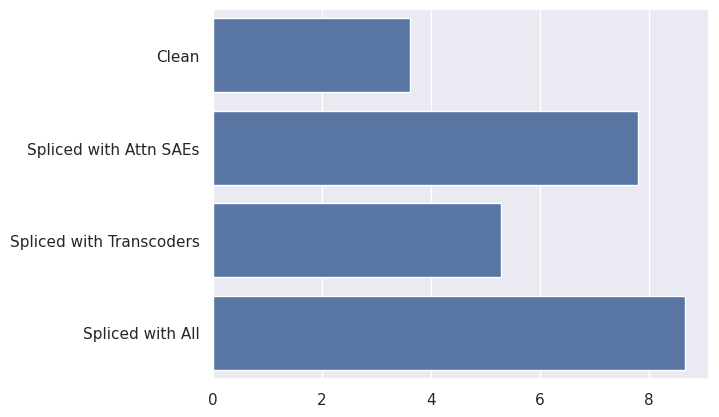

In [8]:
names = ["Clean", "Spliced with Attn SAEs", "Spliced with Transcoders", "Spliced with All"]
values = [clean_loss, all_attn_splice_loss, all_transcoder_splice_loss, all_splice_loss]

sns.barplot(y = names, x = values)

In [9]:
# Splicing from layer 3 onwards only 

for attn_sae in attn_saes:
    attn_sae.cfg.use_error_term = False
for transcoder in transcoders:
    transcoder.cfg.use_error_term = False


# Get loss when splicing in all SAEs together
all_attn_splice_loss = get_avg_ce_loss(model, [], attn_saes[3:], dataset)
# Get loss when splicing in all transcoders together
all_transcoder_splice_loss = get_avg_ce_loss(model, transcoders[3:], [], dataset)
# Get loss when splicing in both SAEs and transcoders
all_splice_loss = get_avg_ce_loss(model, transcoders[3:], attn_saes[3:], dataset)

for transcoder in transcoders:
    transcoder.cfg.use_error_term = True
for attn_sae in attn_saes:
    attn_sae.cfg.use_error_term = True

0 9
9 0
9 9


Text(0.5, 1.0, 'Splicing layer 3 onwards')

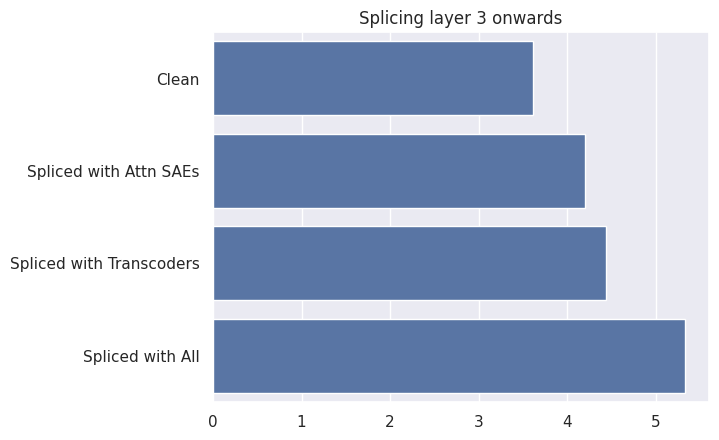

In [12]:
names = ["Clean", "Spliced with Attn SAEs", "Spliced with Transcoders", "Spliced with All"]
values = [clean_loss, all_attn_splice_loss, all_transcoder_splice_loss, all_splice_loss]

sns.barplot(y = names, x = values)
plt.title("Splicing layer 3 onwards")